<a href="https://colab.research.google.com/github/GloryTrizza/Credit-Risk---Loan-Approval/blob/main/Credit_Risk_Loan_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
pip install dask[dataframe]

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lightgbm import LGBMClassifier
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
data = pd.read_csv('/content/drive/MyDrive/credit_risk_dataset.csv')
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [52]:
dups = data.duplicated()

In [53]:
data[dups]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [54]:
data.query("person_age==23 & person_income==42000 & person_home_ownership=='RENT' & loan_int_rate==9.99")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
6464,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4


In [55]:
data.shape

(32581, 12)

In [56]:
data.drop_duplicates(inplace=True)

In [57]:
data.shape

(32416, 12)

In [58]:
# X and y will be thought of as the entire training data
# X_test and y_test will be thought of as the out of sample data for model evaluation

X, X_test, y, y_test = train_test_split(data.drop('loan_status', axis=1), data['loan_status'], test_size=0.2, random_state=0,
                                        stratify = data['loan_status'], shuffle=True)

In [59]:
data['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
0,0.781312
1,0.218688


In [60]:
y.value_counts(normalize=True)

,proportion
loan_status,
0,0.781313
1,0.218687


In [61]:
y_test.value_counts(normalize=True)

,proportion
loan_status,
0,0.781308
1,0.218692


In [62]:
np.round(X.isna().sum()*100 / X.shape[0],3)

,0
person_age,0.000
person_income,0.000
person_home_ownership,0.000
person_emp_length,2.800
loan_intent,0.000
loan_grade,0.000
loan_amnt,0.000
loan_int_rate,9.614
loan_percent_income,0.000
cb_person_default_on_file,0.000


In [63]:
X.shape

(25932, 11)

In [64]:
X[['person_income', 'loan_amnt', 'loan_percent_income']].head()

,person_income,loan_amnt,loan_percent_income
21415,48000,10000,0.21
12916,85000,7500,0.09
2938,125000,3000,0.02
19114,62000,2300,0.04
6057,48000,4200,0.09


In [65]:
for col in X:
  print(col, '-->', X[col].nunique())
  if X[col].nunique() < 20:
    print(X[col].value_counts(normalize=True)*100)
  print()

person_age --> 58

person_income --> 3680

person_home_ownership --> 4
person_home_ownership
RENT        50.320068
MORTGAGE    41.439149
OWN          7.916859
OTHER        0.323924
Name: proportion, dtype: float64

person_emp_length --> 36

loan_intent --> 6
loan_intent
EDUCATION            19.809502
MEDICAL              18.787598
VENTURE              17.542033
PERSONAL             16.878760
DEBTCONSOLIDATION    15.968687
HOMEIMPROVEMENT      11.013420
Name: proportion, dtype: float64

loan_grade --> 7
loan_grade
A    32.932284
B    32.126330
C    19.902052
D    11.121394
E     3.004010
F     0.732685
G     0.181243
Name: proportion, dtype: float64

loan_amnt --> 710

loan_int_rate --> 346

loan_percent_income --> 75

cb_person_default_on_file --> 2
cb_person_default_on_file
N    82.392411
Y    17.607589
Name: proportion, dtype: float64

cb_person_cred_hist_length --> 29



In [66]:
num_cols = [col for col in X if X[col].dtypes != 'O']
num_cols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

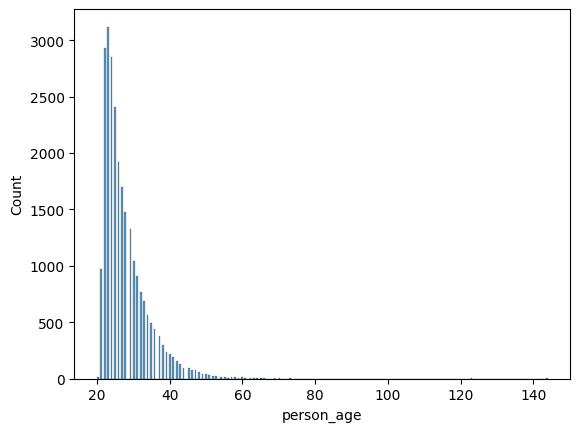

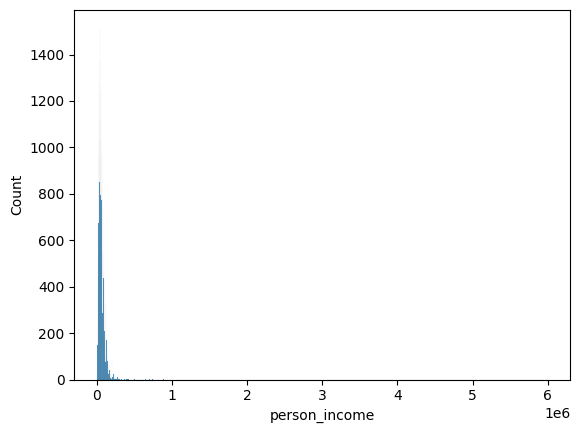

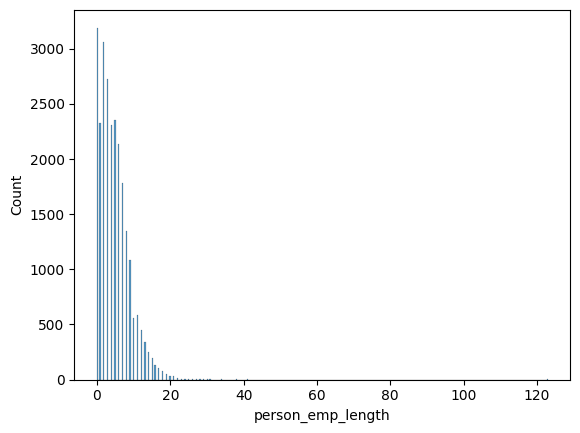

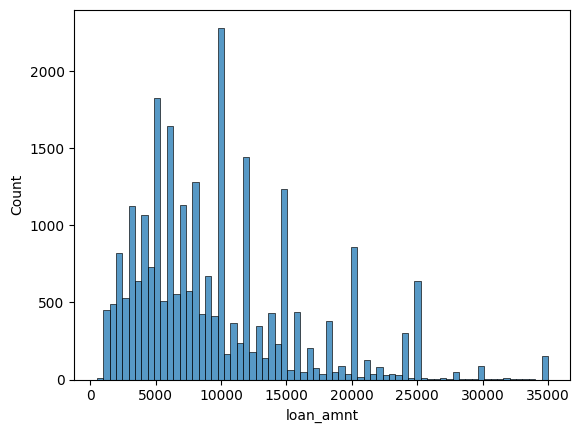

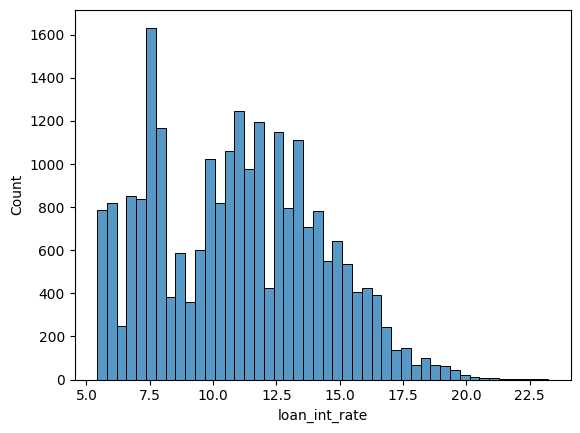

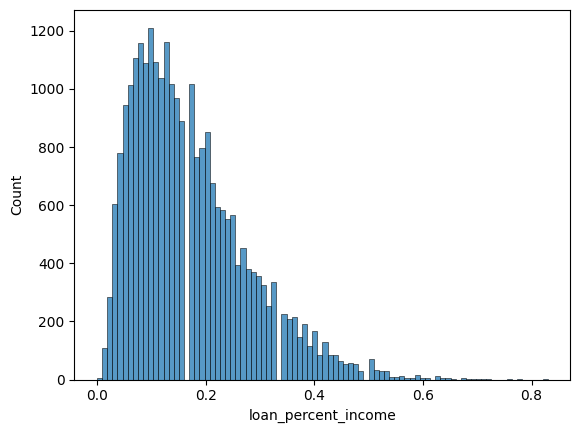

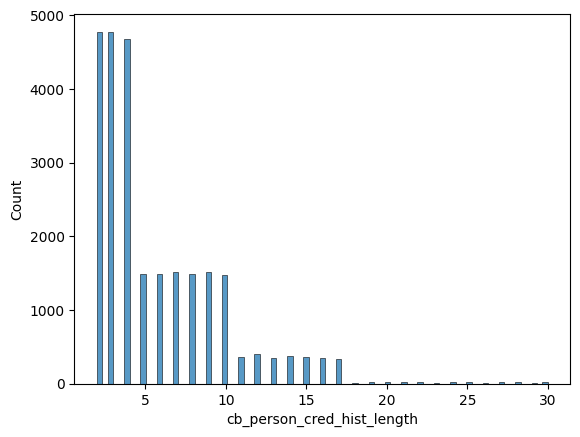

In [67]:
for col in num_cols:
  sns.histplot(X[col])
  plt.show()

In [68]:
X.loc[X['person_age'] >= 80, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32422,80,64000,RENT,7.0,MEDICAL,B,6800,11.71,0.11,N,25
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0.27,N,27
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0.26,N,4
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0.11,N,24
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25


In [69]:
X.loc[X['person_age'] < 80, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
21415,33,48000,OWN,11.0,HOMEIMPROVEMENT,B,10000,9.99,0.21,N,8
12916,25,85000,MORTGAGE,5.0,DEBTCONSOLIDATION,C,7500,11.03,0.09,Y,3
2938,26,125000,RENT,10.0,MEDICAL,B,3000,12.21,0.02,N,4
19114,29,62000,RENT,4.0,DEBTCONSOLIDATION,C,2300,13.43,0.04,Y,6
6057,24,48000,MORTGAGE,4.0,MEDICAL,B,4200,11.99,0.09,N,4
...,...,...,...,...,...,...,...,...,...,...,...
23921,29,67422,MORTGAGE,13.0,EDUCATION,B,12800,11.49,0.19,N,8
27783,29,195000,MORTGAGE,5.0,VENTURE,C,3600,14.26,0.02,N,7
24358,27,72000,OWN,2.0,EDUCATION,B,12000,9.99,0.17,N,9
2544,23,30000,RENT,0.0,MEDICAL,A,3000,5.79,0.10,N,3


In [70]:
X.loc[X['person_emp_length'] >= 66, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.10,N,4
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3


In [71]:
data.query("person_age<=person_emp_length+14")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


In [72]:
X = X.loc[(X['person_emp_length']<66) | (X['person_emp_length'].isna()), :]

In [73]:
# since we've removed some data from X, we need to pass on these updates to y as well,
# as y doesn't know some of its corresponding Xs have been deleted
y = y[X.index]

In [74]:
cat_cols = [col for col in X if X[col].dtypes == 'O']
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [75]:
num_pipe = Pipeline([
    ('impute', IterativeImputer()),
    ('scale', StandardScaler())
])

In [76]:
ct = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [77]:
grid = {
    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'): {
        'model__n_estimators': [100, 200],
        'model__max_depth': [5, 9],
        'model__min_samples_split': [6],
        'coltf__num__impute__estimator': [LinearRegression()]
    }
}

In [78]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [100, 200], 'model__max_depth': [5, 9], 'model__min_samples_split': [6], 'coltf__num__impute__estimator': [LinearRegression()]}




In [79]:
# Initialize empty dataframe and list to store data
full_data = pd.DataFrame()
best_algos = {}
temp_data = []  # List to collect data

for clf, param in grid.items():
    # Define the pipeline
    pipe = Pipeline([
        ('coltf', ct),
        ('model', clf)
    ])

    # Set up RandomizedSearchCV
    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=2, cv=3)

    # Fit the model
    gs.fit(X, y)

    # Extract and store results
    all_res = pd.DataFrame(gs.cv_results_)
    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name
    temp_data.append(temp)

    # Store the best algorithm
    best_algos[algo_name] = gs.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [80]:
# Concatenate all temporary dataframes into full_data
full_data = pd.concat(temp_data, ignore_index=True)

In [81]:
full_data.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
1,"{'model__n_estimators': 200, 'model__min_sampl...",0.876437,RandomForestClassifier
0,"{'model__n_estimators': 100, 'model__min_sampl...",0.872040,RandomForestClassifier


In [82]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_split=6, n_estimators=200,
                                        n_jobs=-1, random_state=0))])

In [83]:
be.fit(X, y)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_split=6, n_estimators=200,
                                        n_jobs=-1, random_state=0))])

In [84]:
preds = be.predict(X_test)

In [85]:
confusion_matrix(y_test, preds)

array([[4572,  494],
       [ 349, 1069]])

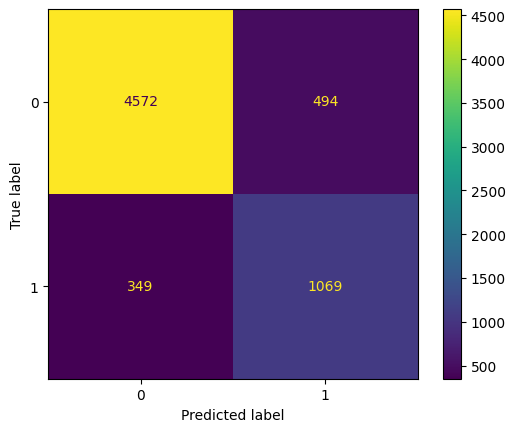

In [86]:
disp = ConfusionMatrixDisplay.from_estimator(be, X_test, y_test)

In [87]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      5066
           1       0.68      0.75      0.72      1418

    accuracy                           0.87      6484
   macro avg       0.81      0.83      0.82      6484
weighted avg       0.88      0.87      0.87      6484



In [88]:
be.score(X_test, y_test)



0.8699876619370759

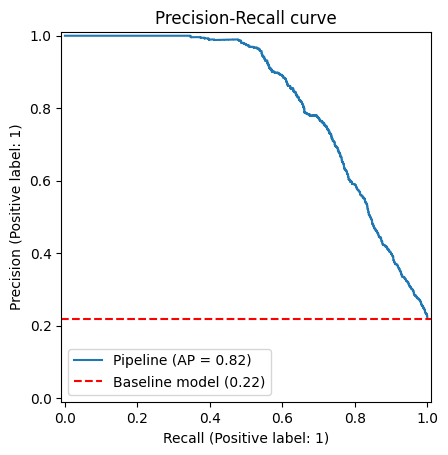

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(be, X_test, y_test)
display.ax_.set_title("Precision-Recall curve")

baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')
plt.show()

In [ ]:
a, b, c = learning_curve(be, X, y, n_jobs=-1, cv=3)

In [ ]:
a

In [ ]:
b

In [ ]:
c

In [ ]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()